In [2]:
from a4_utils import *
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math


def gauss(sigma):
    gauss_kernel = []
    for x in range(math.floor(- 3 * sigma), math.ceil(3 * sigma) + 1):
        result_x = (1 / (math.sqrt(2 * math.pi) * sigma)) * \
            math.exp(-((x ** 2) / (2 * (sigma ** 2))))
        gauss_kernel.append(result_x)
    return np.array(gauss_kernel) / sum(gauss_kernel)

def gaussdx(sigma):
    gaussdx_kernel = []
    for x in range(math.floor(- 3 * sigma), math.ceil(3 * sigma) + 1):
        result_x = (-1 / (math.sqrt(2 * math.pi) * sigma ** 3)) * x * math.exp(-(x ** 2 / (2 * sigma ** 2)))
        gaussdx_kernel.append(result_x)
    return np.array(gaussdx_kernel) / sum(np.abs(gaussdx_kernel))

def compute_derivative(img, sigma):
    G=gauss(sigma).reshape(1,-1)
    GT=G.T
    G=np.flip(G)
    GT=np.flip(GT)

    D=gaussdx(sigma).reshape(1,-1)
    DT=D.T
    D=np.flip(D)
    DT=np.flip(DT)

    img_Gt = cv2.filter2D(img, -1, D)
    deriv_x = cv2.filter2D(img_Gt, -1, GT)
    img_G = cv2.filter2D(img, -1, G)
    deriv_y = cv2.filter2D(img_G, -1, DT)
    return deriv_x, deriv_y

def gaussfilter(img, sigma):
    G = gauss(sigma)
    G = G.reshape(1, -1)
    convolved_img = cv2.filter2D(img, -1, G)
    convolved_img = cv2.filter2D(convolved_img, -1, G.T)
    return convolved_img

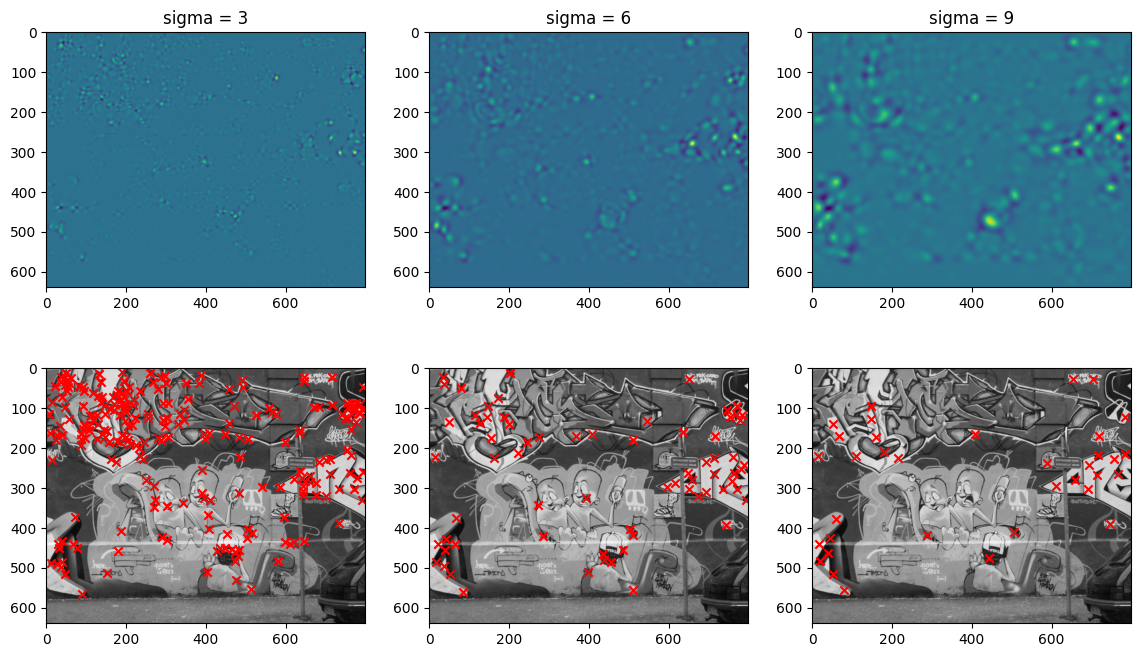

In [3]:
# Implement a function hessian_points, that computes a Hessian determinant
# using the equation for each pixel of the input image.

def nonmaxima_suppression(det,thresh,box_size):
    h,w=det.shape

    suppressed=np.zeros((h,w))

    for i in range(h):
        for j in range(w):
            if det[i,j]>thresh:
                box=det[i-box_size//2:i+box_size//2+1,j-box_size//2:j+box_size//2+1]
                if box.size>0:
                    max_val=np.max(box)
                else:
                    max_val=0
                if det[i,j] == max_val:
                    suppressed[i,j] = 1
    return suppressed

def hessian_points(I, sigma, threshold):
    Ix, Iy = compute_derivative(I, sigma)
    Ixx,Ixy = compute_derivative(Ix,sigma)
    Iyx,Iyy = compute_derivative(Iy,sigma)

    H=np.zeros((I.shape[0],I.shape[1],2,2))
    H[:,:,0,0]=Ixx
    H[:,:,0,1]=Ixy
    H[:,:,1,0]=Iyx
    H[:,:,1,1]=Iyy

    det= H[:,:,0,0]*H[:,:,1,1]-H[:,:,0,1]*H[:,:,1,0] 
    return det


def plot_points_hessian(I_gray, threshold):
    det_3 = hessian_points(I_gray, 3, threshold)
    det_6 = hessian_points(I_gray, 6, threshold)
    det_9 = hessian_points(I_gray, 9, threshold)
    suppressed_3 = nonmaxima_suppression(det_3, threshold, 3)
    suppressed_6 = nonmaxima_suppression(det_6, threshold, 3)
    suppressed_9 = nonmaxima_suppression(det_9, threshold, 3)

    plt.figure(figsize=(14,8))
    plt.subplot(2,3,1)
    plt.imshow(det_3)
    plt.title("sigma = 3")
    plt.subplot(2,3,2)
    plt.imshow(det_6)
    plt.title("sigma = 6")
    plt.subplot(2,3,3)
    plt.imshow(det_9)
    plt.title("sigma = 9")
    plt.subplot(2,3,4)
    plt.imshow(I_gray, cmap='gray')
    plt.scatter(np.where(suppressed_3==1)[1],np.where(suppressed_3==1)[0],c='r',marker='x')    
    plt.subplot(2,3,5)
    plt.imshow(I_gray, cmap='gray')
    plt.scatter(np.where(suppressed_6==1)[1],np.where(suppressed_6==1)[0],c='r',marker='x')   
    plt.subplot(2,3,6)
    plt.imshow(I_gray, cmap='gray')
    plt.scatter(np.where(suppressed_9==1)[1],np.where(suppressed_9==1)[0],c='r', marker='x')    
    plt.show()

graf_a_original = cv2.imread("data/graf/graf_a.jpg")
graf_a_original = cv2.cvtColor(graf_a_original, cv2.COLOR_BGR2RGB)

graf_a_grayscale = cv2.imread("data/graf/graf_a.jpg", cv2.IMREAD_GRAYSCALE) / 255

plot_points_hessian(graf_a_grayscale, 0.004)

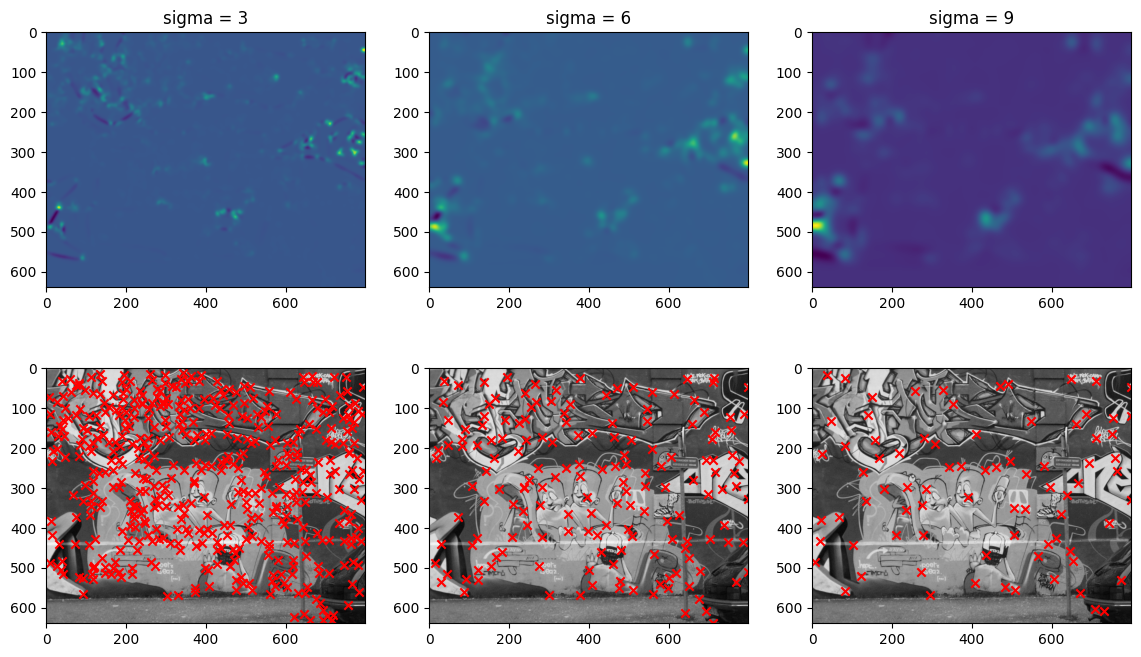

In [4]:

# (b) Implement the Harris feature point detector

def harris_points(I, sigma, threshold):
    sigma2 = 1.6 * sigma
    alpha = 0.06
    harris = np.zeros(I.shape)
    C = np.zeros((I.shape[0], I.shape[1], 2, 2))
    Ix,Iy=compute_derivative(I,sigma)

    C[:, :, 0, 0] = gaussfilter(Ix * Ix, sigma2)
    C[:, :, 0, 1] = gaussfilter(Ix * Iy, sigma2)
    C[:, :, 1, 0] = gaussfilter(Ix * Iy, sigma2)
    C[:, :, 1, 1] = gaussfilter(Iy * Iy, sigma2)

    det = C[:,:,0,0]*C[:,:,1,1]-C[:,:,0,1]*C[:,:,1,0]
    trace = C[:, :, 0, 0] + C[:, :, 1, 1]
    harris = det - alpha * trace * trace
    return harris

def plot_points_harris(I_gray, threshold):
    det_3 = harris_points(I_gray, 3, threshold)
    det_6 = harris_points(I_gray, 6, threshold)
    det_9 = harris_points(I_gray, 9, threshold)
    suppressed_3 = nonmaxima_suppression(det_3, threshold, 3)
    suppressed_6 = nonmaxima_suppression(det_6, threshold, 3)
    suppressed_9 = nonmaxima_suppression(det_9, threshold, 3)

    plt.figure(figsize=(14,8))
    plt.subplot(2,3,1)
    plt.imshow(det_3)
    plt.title("sigma = 3")
    plt.subplot(2,3,2)
    plt.imshow(det_6)
    plt.title("sigma = 6")
    plt.subplot(2,3,3)
    plt.imshow(det_9)
    plt.title("sigma = 9")
    plt.subplot(2,3,4)
    plt.imshow(I_gray, cmap='gray')
    plt.scatter(np.where(suppressed_3==1)[1],np.where(suppressed_3==1)[0],c='r',marker='x')    
    plt.subplot(2,3,5)
    plt.imshow(I_gray, cmap='gray')
    plt.scatter(np.where(suppressed_6==1)[1],np.where(suppressed_6==1)[0],c='r',marker='x')   
    plt.subplot(2,3,6)
    plt.imshow(I_gray, cmap='gray')
    plt.scatter(np.where(suppressed_9==1)[1],np.where(suppressed_9==1)[0],c='r', marker='x')    
    plt.show()


plot_points_harris(graf_a_grayscale, 0.000001)